# [Plotting Neural Network Training Curves](https://github.com/dmbee/seglearn/blob/master/examples/plot_nn_training_curves.py)

This is a basic example using a convolutional recurrent neural network to learn segments directly from time series data.

**Author:** David Burns

**Modifications:** Alex Araujo

**License**: BSD

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import numpy as np
import matplotlib.pyplot as plt

from pandas import DataFrame

from seglearn.datasets import load_watch
from seglearn.pipe import Pype
from seglearn.transform import SegmentX

from sklearn.model_selection import train_test_split

from keras.layers import Dense, LSTM, Conv1D, BatchNormalization
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model

%matplotlib inline

Using TensorFlow backend.


In [4]:
# Simple neural network model.
def crnn_model(width=100,
               n_vars=6,
               n_classes=7,
               conv_kernel_size=5,
               conv_filters=10,
               lstm_units=10):
    
    # Archtecture.
    input_shape = (width, n_vars)
    model = Sequential()
    model.add(Conv1D(filters=conv_filters,
                     kernel_size=conv_kernel_size,
                     padding="valid",
                     activation="relu",
                     input_shape=input_shape))
    model.add(LSTM(units=lstm_units,
                   dropout=0.1,
                   recurrent_dropout=0.1))
    model.add(Dense(units=n_classes,
                    activation="softmax"))
    
    # Compilation.
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

    print(">>> Input:", model.input)
    
    return model

In [5]:
# Modification of the previous simple neural network model.
def crnn_model_v2(width=100,
                  n_features=6,
                  n_classes=7,
                  conv_kernel_size=10,
                  conv_filters=20,
                  lstm_units=10):
    
    # Archtecture.
    input_shape = (width, n_features)
    model = Sequential()
    model.add(Conv1D(filters=conv_filters,
                     kernel_size=conv_kernel_size,
                     padding="valid",
                     activation="relu",
                     input_shape=input_shape))
    model.add(LSTM(units=lstm_units,
                   dropout=0.2,
                   recurrent_dropout=0.2,
                   return_sequences=False))
    model.add(BatchNormalization(axis=-1))
    model.add(Dense(units=n_classes,
                    activation="softmax"))
    
    # Compilation.
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

    print(">>> Input:", model.input)
    
    return model

In [6]:
model = crnn_model()
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


>>> Input: Tensor("conv1d_1_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 96, 10)            310       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 77        
Total params: 1,227
Trainable params: 1,227
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_v2 = crnn_model_v2()
model_v2.summary()

>>> Input: Tensor("conv1d_2_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 91, 20)            1220      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1240      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 77        
Total params: 2,577
Trainable params: 2,557
Non-trainable params: 20
_________________________________________________________________


In [8]:
# Show it.
FILE = "./figures/convolutional_recurrent_neural_network.png"
plot_model(model=model, to_file=FILE, show_shapes=True)

![net](./figures/convolutional_recurrent_neural_network.png)

In [9]:
# Show it.
FILE2 = "./figures/convolutional_recurrent_neural_network2.png"
plot_model(model=model_v2, to_file=FILE2, show_shapes=True)

![net2](./figures/convolutional_recurrent_neural_network2.png)

In [10]:
# Load the data.
data = load_watch()
X = data["X"]
Y = data["y"]

In [11]:
# Split the data.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print(">>> Train")
print("* X list len:", len(X_train))
print("\n>>> Test")
print("* X list len:", len(X_test))

>>> Train
* X list len: 105

>>> Test
* X list len: 35


In [12]:
# Create a segment learning pipeline.
width = 100
pipe = Pype([("seg", SegmentX(order="C")),
             ("crnn", KerasClassifier(build_fn=crnn_model, 
                                      epochs=500, 
                                      batch_size=256,
                                      verbose=0, 
                                      validation_split=0.2))])

In [13]:
width = 100
pipe2 = Pype([("seg", SegmentX(order="C")),
              ("crnn", KerasClassifier(build_fn=crnn_model_v2, 
                                       epochs=500, 
                                       batch_size=256,
                                       verbose=0, 
                                       validation_split=0.2))])

In [14]:
%%time

# This is a bit of a hack, because history object is returned by the keras wrapper when fit is
# called. This approach won't work with a more complex estimator pipeline, in which case a 
# callable class with the desired properties should be made passed to build_fn.
pipe.fit(X_train, y_train)
print(DataFrame(pipe.history.history))
ac_train = pipe.history.history["acc"]
ac_val = pipe.history.history["val_acc"]
epoch = np.arange(len(ac_train)) + 1

>>> Input: Tensor("conv1d_3_input:0", shape=(?, 100, 6), dtype=float32)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
     val_loss   val_acc      loss       acc
0    1.989403  0.079545  1.923691  0.164121
1    1.971129  0.080966  1.880630  0.204973
2    1.950835  0.095170  1.850068  0.225577
3    1.938696  0.099432  1.819433  0.251155
4    1.919019  0.117898  1.783035  0.271758
5    1.885860  0.153409  1.735234  0.284192
6    1.841802  0.186080  1.677708  0.324334
7    1.803506  0.208807  1.620987  0.363766
8    1.764887  0.228693  1.564634  0.391829
9    1.722922  0.252841  1.507556  0.428419
10   1.612482  0.282670  1.439450  0.456838
11   1.532013  0.319602  1.384390  0.490231
12   1.479521  0.345170  1.324069  0.522913
13   1.382817  0.384943  1.264796  0.542096
14   1.323490  0.403409  1.222185  0.561989
15   1.284705  0.411932  1.172556  0.576909
16   1.203297  0.447443  1.135684  0.596803
17   1.170235  0.470170  1.095693  0.60710

In [15]:
%%time

pipe2.fit(X_train, y_train)
print(DataFrame(pipe2.history.history))
ac_train2 = pipe2.history.history["acc"]
ac_val2 = pipe2.history.history["val_acc"]
epoch2 = np.arange(len(ac_train2)) + 1

>>> Input: Tensor("conv1d_4_input:0", shape=(?, 100, 6), dtype=float32)
     val_loss   val_acc      loss       acc
0    1.839794  0.330966  2.144313  0.202487
1    1.713915  0.340909  1.836076  0.279218
2    1.632992  0.366477  1.668889  0.336767
3    1.566194  0.390625  1.544522  0.368384
4    1.511125  0.414773  1.449275  0.397158
5    1.462427  0.441761  1.360140  0.434103
6    1.408416  0.481534  1.303356  0.448313
7    1.363075  0.487216  1.242980  0.483837
8    1.323058  0.500000  1.197044  0.495915
9    1.259136  0.536932  1.145292  0.509769
10   1.250179  0.509943  1.110471  0.554529
11   1.225357  0.488636  1.062902  0.567318
12   1.193745  0.480114  1.034240  0.561279
13   1.139749  0.524148  0.988658  0.601421
14   1.091873  0.553977  0.972262  0.581172
15   1.080378  0.534091  0.927912  0.604618
16   1.055568  0.539773  0.896447  0.619183
17   1.024545  0.538352  0.872516  0.619893
18   1.031066  0.504261  0.850438  0.621670
19   1.004932  0.507102  0.827452  0.640497
20  

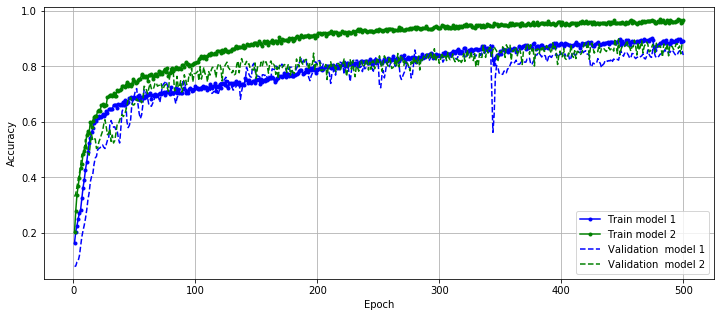

In [17]:
# Training Curves.
plt.figure(figsize=(12, 5))
plt.plot(epoch, ac_train, ".-b", label="Train model 1")
plt.plot(epoch2, ac_train2, ".-g", label="Train model 2")
plt.plot(epoch, ac_val, "--b", label="Validation  model 1")
plt.plot(epoch2, ac_val2, "--g", label="Validation  model 2")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid();